Read Data

In [181]:
import json

with open("conversation_data.json", "r", encoding="utf-8") as file:
    data = json.load(file)

JSON to DataFrame

In [182]:
import pandas as pd

conversations = []
messages = []

for conv_num in data["conversations"]:
  conversations.append({
      "conversation_id": conv_num["conversation_id"],
      "user_id": conv_num["metadata"]["user_id"],
      "timestamp": conv_num["timestamp"],
      "duration": conv_num["duration"],
      "satisfaction_score": conv_num["metadata"]["satisfaction_score"],
      "resolved": conv_num["metadata"]["resolved"],
      "category": conv_num["metadata"]["category"],
      "priority": conv_num["metadata"]["priority"],
      "platform": conv_num["metadata"]["platform"],
      "first_time_user": conv_num["metadata"]["first_time_user"],
      "message_count": len(conv_num["messages"]),
      "tags": ", ".join(conv_num["metadata"].get("tags", [])),
      })

  for msg_num in conv_num["messages"]:
    messages.append({
        "conversation_id": conv_num["conversation_id"],
        "message_id": msg_num["id"],
        "timestamp": msg_num["timestamp"],
        "sender": msg_num["sender"],
        "text": msg_num["text"],
        "response_time": msg_num["response_time"],
        })

df_conversations = pd.DataFrame(conversations)
df_messages = pd.DataFrame(messages)

Data Preprocessing and Quality Issues (TimeStamp, Duration and Satisfaction Score)

In [183]:
# timestamp to datetime format
df_conversations["timestamp"] = pd.to_datetime(df_conversations["timestamp"], utc=True)
df_messages["timestamp"] = pd.to_datetime(df_messages["timestamp"], utc=True)

# if duration is null, calculate it
for index, row in df_conversations.iterrows():
  if pd.isnull(row["duration"]):
    conv_id = row["conversation_id"]
    conv_messages = df_messages[df_messages["conversation_id"] == conv_id]

    if not conv_messages.empty:
      start_time = conv_messages["timestamp"].min()
      end_time = conv_messages["timestamp"].max()
      duration = (end_time - start_time).total_seconds()
      df_conversations.at[index, "duration"] = duration

# if satisfaction_score is NaN, we will try to infer score based on conversation outcome
mean_resolved = df_conversations[df_conversations["resolved"] == True]["satisfaction_score"].mean()
mean_unresolved = df_conversations[df_conversations["resolved"] == False]["satisfaction_score"].mean()

df_conversations.loc[(df_conversations["satisfaction_score"].isna()) & (df_conversations["resolved"] == True), "satisfaction_score"] = mean_resolved
df_conversations.loc[(df_conversations["satisfaction_score"].isna()) & (df_conversations["resolved"] == False), "satisfaction_score"] = mean_unresolved

# flag if message text is missing
df_messages["is_missing"] = df_messages["text"].isna()

# flag if message text is duplicated
df_messages["is_duplicate"] = df_messages.duplicated(subset=["conversation_id", "text"], keep='first')

Export processed data to a queryable format

In [184]:
import pyarrow

df_conversations.to_parquet("conversations.parquet", engine="pyarrow", index=False)
df_messages.to_parquet("messages.parquet", engine="pyarrow", index=False)

Metrics by time period (Date and Day of Week)

In [185]:
df_conversations["date"] = df_conversations["timestamp"].dt.date
df_conversations["day_of_week"] = df_conversations["timestamp"].dt.day_name()

daily_metrics = df_conversations.groupby("date").agg(
    total_conversations=("conversation_id", "count"),
    avg_duration=("duration", "mean"),
    resolved_rate=("resolved", "mean"),
    avg_satisfaction=("satisfaction_score", "mean"),
)

weekly_metrics = df_conversations.groupby("day_of_week").agg(
    total_conversations=("conversation_id", "count"),
    avg_duration=("duration", "mean"),
    resolved_rate=("resolved", "mean"),
    avg_satisfaction=("satisfaction_score", "mean"),
).reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

print("Daily Metrics:\n", daily_metrics)
print("\nWeekly Metrics:\n", weekly_metrics)

Daily Metrics:
             total_conversations  avg_duration  resolved_rate  avg_satisfaction
date                                                                          
2025-01-11                   28    359.750000       0.678571          2.975777
2025-01-12                   33    370.424242       0.757576          3.431263
2025-01-13                   31    353.483871       0.838710          2.946143
2025-01-14                   30    348.300000       0.800000          2.974245
2025-01-15                   33    381.151515       0.636364          2.732732
2025-01-16                   38    438.447368       0.684211          3.058729
2025-01-17                   37    334.027027       0.648649          3.330352
2025-01-18                   30    404.200000       0.733333          3.436192
2025-01-19                   28    408.750000       0.535714          3.077863
2025-01-20                   28    391.750000       0.714286          3.793834
2025-01-21                   31    3

Average Response Time / Conversation

In [186]:
df_responses_by_agent = df_messages[df_messages["sender"] == "agent"]

response_time_per_conv = df_responses_by_agent.groupby("conversation_id")["response_time"].mean().reset_index()
response_time_per_conv.rename(columns={"response_time": "avg_response_time"}, inplace=True)

response_time_per_conv

,conversation_id,avg_response_time
0,0041fcf1-b75d-43e6-b293-4df42cb54d3a,36.000000
1,0056711c-30cc-4738-9f4b-fa5146f70007,32.800000
2,007b8557-f8cf-40e2-ac41-08b18990d30c,34.333333
3,0082e3db-8ffa-40e4-b631-5194ea8aa6a0,32.200000
4,00aecbcf-79db-4c8d-8fa2-0bf50b91c981,25.250000
...,...,...
995,fee232cf-53fd-4961-8e82-d54943f702bd,21.750000
996,feec92c1-9af1-4667-b609-0f5db50ce6b7,22.000000
997,ff1e216f-a7ff-46ec-9eee-821f43d9a55f,32.000000
998,ff2d9626-fa64-4932-8fcd-d743e74d97cf,12.000000


Message Count Distribution

In [187]:
message_count_dist = df_messages.groupby("conversation_id")["message_id"].count().reset_index()
message_count_dist.rename(columns={"message_id": "message_count"}, inplace=True)

message_count_dist

,conversation_id,message_count
0,0041fcf1-b75d-43e6-b293-4df42cb54d3a,3
1,0056711c-30cc-4738-9f4b-fa5146f70007,10
2,007b8557-f8cf-40e2-ac41-08b18990d30c,6
3,0082e3db-8ffa-40e4-b631-5194ea8aa6a0,10
4,00aecbcf-79db-4c8d-8fa2-0bf50b91c981,8
...,...,...
995,fee232cf-53fd-4961-8e82-d54943f702bd,8
996,feec92c1-9af1-4667-b609-0f5db50ce6b7,8
997,ff1e216f-a7ff-46ec-9eee-821f43d9a55f,9
998,ff2d9626-fa64-4932-8fcd-d743e74d97cf,9


Conversation Duration Statistics

In [188]:
import numpy as np

durations = df_conversations["duration"]

duration_stats = {
    "Mean Duration (seconds)": np.mean(durations),
    "Median Duration (seconds)": np.median(durations),
    "Min Duration (seconds)": np.min(durations),
    "Max Duration (seconds)": np.max(durations),
    "Standard Deviation": np.std(durations),
    "90th Percentile": np.percentile(durations, 90),
    "95th Percentile": np.percentile(durations, 95),
}

duration_stats

{'Mean Duration (seconds)': 378.325,
 'Median Duration (seconds)': 340.0,
 'Min Duration (seconds)': 31.0,
 'Max Duration (seconds)': 1080.0,
 'Standard Deviation': 238.49330257891958,
 '90th Percentile': 721.7000000000002,
 '95th Percentile': 833.0}

Resolution Rate / Time

In [189]:
res_rate = df_conversations.groupby("date").agg(total_conversations=("conversation_id", "count"), resolved_conversations=("resolved", "sum")).reset_index()
res_rate["resolution_rate"] = (res_rate["resolved_conversations"] / res_rate["total_conversations"]) * 100

res_rate

,date,total_conversations,resolved_conversations,resolution_rate
0,2025-01-11,28,19,67.857143
1,2025-01-12,33,25,75.757576
2,2025-01-13,31,26,83.870968
3,2025-01-14,30,24,80.000000
4,2025-01-15,33,21,63.636364
5,2025-01-16,38,26,68.421053
6,2025-01-17,37,24,64.864865
7,2025-01-18,30,22,73.333333
8,2025-01-19,28,15,53.571429
9,2025-01-20,28,20,71.428571


User Satisfaction Trend

In [190]:
# user satisfaction by platform
satisfaction_by_platform = df_conversations.groupby(["date", "platform"])["satisfaction_score"].mean().reset_index()

satisfaction_by_platform

# user satisfaction by use
satisfaction_by_use = df_conversations.groupby(["date", "first_time_user"])["satisfaction_score"].mean().reset_index()

satisfaction_by_use

# user satisfaction by category
satisfaction_by_category = df_conversations.groupby(["date", "category"])["satisfaction_score"].mean().reset_index()

satisfaction_by_category

# user satisfaction by number of messages
satisfaction_by_msg = df_conversations.groupby(["message_count"])["satisfaction_score"].mean().reset_index()

satisfaction_by_msg

# user satisfaction by number of messages / day
satisfaction_by_msg_day = df_conversations.groupby(["date", "message_count"])["satisfaction_score"].mean().reset_index()

satisfaction_by_msg_day

,date,message_count,satisfaction_score
0,2025-01-11,2,3.031469
1,2025-01-11,3,1.000000
2,2025-01-11,4,3.010718
3,2025-01-11,5,3.015734
4,2025-01-11,6,4.000000
...,...,...,...
270,2025-02-10,6,2.500000
271,2025-02-10,7,3.209441
272,2025-02-10,8,3.331890
273,2025-02-10,9,3.004818


Peak Conversation Times

In [191]:
df_conversations["hour"] = df_conversations["timestamp"].dt.hour

peak_times = (df_conversations.groupby(["date", "hour"]).size().reset_index(name="conversation_count"))

peak_times

,date,hour,conversation_count
0,2025-01-11,18,28
1,2025-01-12,18,33
2,2025-01-13,18,31
3,2025-01-14,18,30
4,2025-01-15,18,33
5,2025-01-16,18,38
6,2025-01-17,18,37
7,2025-01-18,18,30
8,2025-01-19,18,28
9,2025-01-20,18,28


Common Conversation Patterns

In [192]:
category_resolved_summary = df_conversations.groupby("category")["resolved"].value_counts().unstack(fill_value=0)

category_resolved_summary

df_conversation_expanded = df_conversations.assign(tags=df_conversations["tags"].str.split(", ")).explode("tags")
tags_ag_category = df_conversation_expanded.groupby("tags")["category"].value_counts().unstack(fill_value=0)

tags_ag_category

category,account_issues,billing,feedback,order_tracking,payment_issue,price_match,product_availability,product_inquiry,returns,shipping,technical_issue,unknown,warranty
tags,,,,,,,,,,,,,
,22,15,22,32,20,23,15,22,13,15,22,22,16
escalated,7,17,15,14,19,13,7,13,14,14,17,20,10
follow_up,19,23,17,25,20,16,11,20,16,13,14,26,18
sales,21,13,14,21,13,21,17,10,12,18,16,16,12
spam,21,17,17,21,10,25,17,19,13,14,12,18,12
support,13,12,13,28,18,13,23,15,17,22,13,16,6
urgent,14,12,20,16,13,17,17,17,23,17,19,14,12
vip,19,18,17,28,15,13,17,21,14,13,14,18,13


<ipython-input-193-7b9e1e37916e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_responses_by_agent["date"] = df_responses_by_agent["timestamp"].dt.date


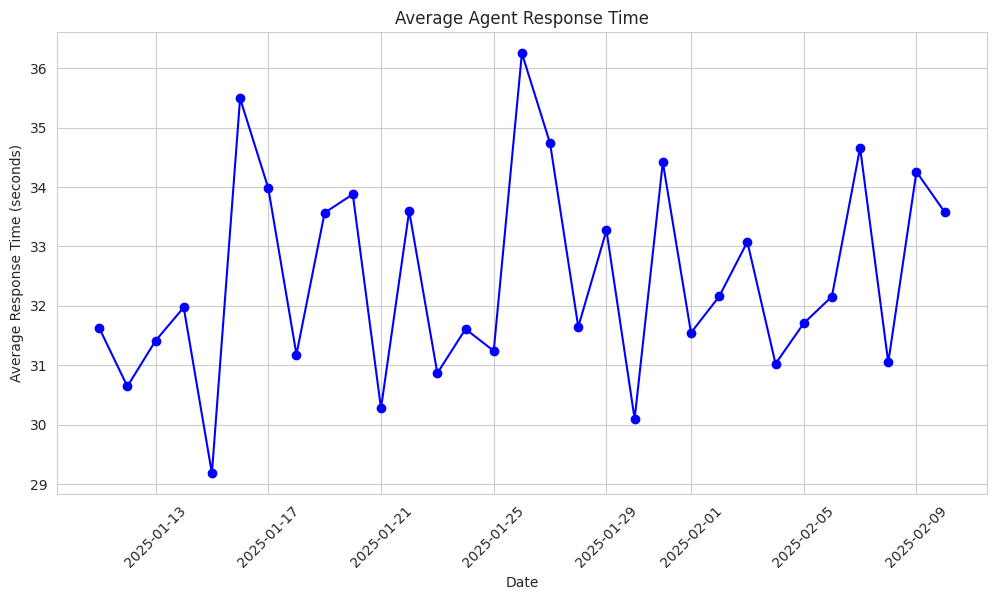

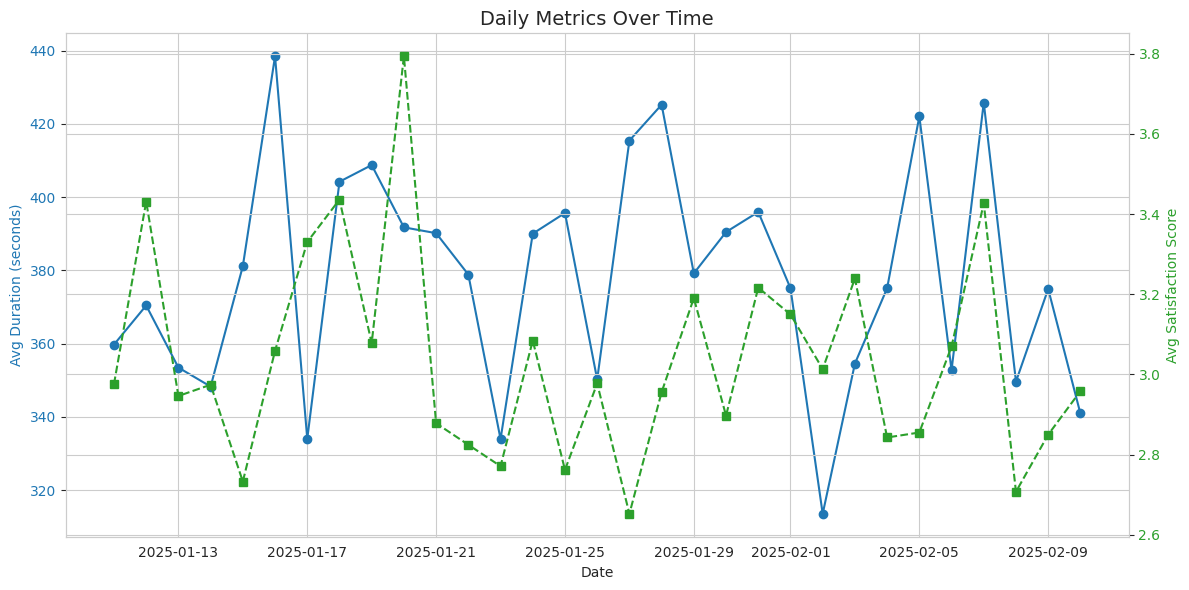

In [193]:
# time series of key metrics
df_responses_by_agent["date"] = df_responses_by_agent["timestamp"].dt.date

response_time_per_conv = df_responses_by_agent.groupby("date")["response_time"].mean().reset_index()
response_time_per_conv.rename(columns={"response_time": "avg_response_time"}, inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(response_time_per_conv["date"], response_time_per_conv["avg_response_time"], marker='o', linestyle='-', color='blue')

plt.xlabel("Date")
plt.ylabel("Average Response Time (seconds)")
plt.title("Average Agent Response Time")
plt.xticks(rotation=45)
plt.grid(True)

plt.show()
print("\n")

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_title("Daily Metrics Over Time", fontsize=14)
ax1.set_xlabel("Date")

ax1.set_ylabel("Avg Duration (seconds)", color="tab:blue")
ax1.plot(daily_metrics.index, daily_metrics["avg_duration"], label="Avg Duration", color="tab:blue", marker="o")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Avg Satisfaction Score", color="tab:green")
ax2.plot(daily_metrics.index, daily_metrics["avg_satisfaction"], label="Avg Satisfaction", color="tab:green", linestyle="dashed", marker="s")
ax2.tick_params(axis="y", labelcolor="tab:green")

fig.tight_layout()
plt.show()

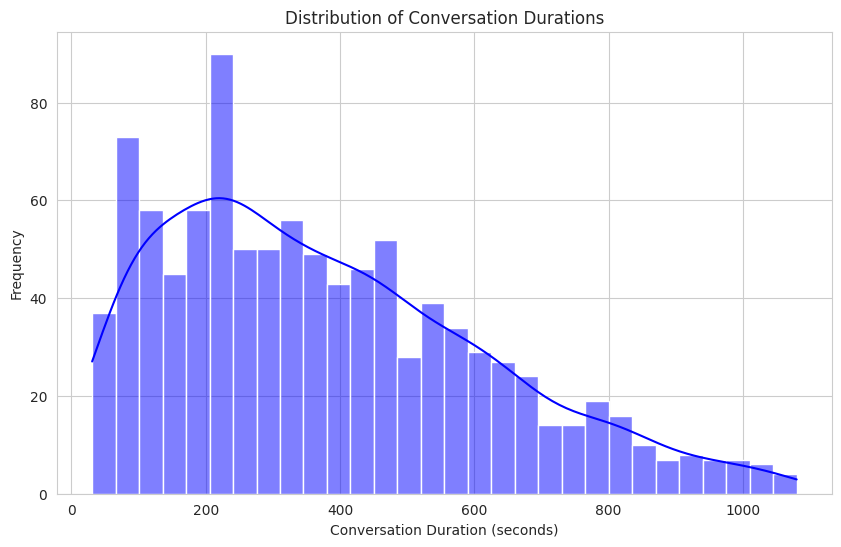

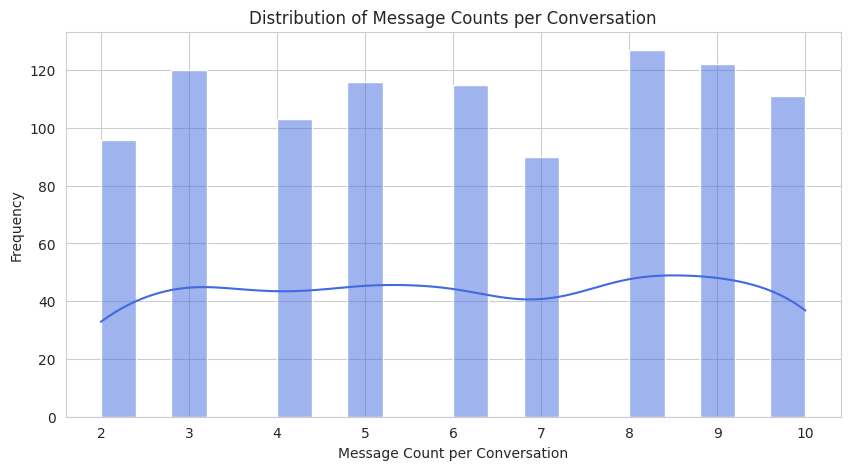

In [194]:
# distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df_conversations['duration'], bins=30, kde=True, color='blue')

plt.xlabel("Conversation Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Conversation Durations")

plt.show()
print("\n")

sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(message_count_dist["message_count"], bins=20, kde=True, color="royalblue")
plt.xlabel("Message Count per Conversation")
plt.ylabel("Frequency")
plt.title("Distribution of Message Counts per Conversation")

plt.show()

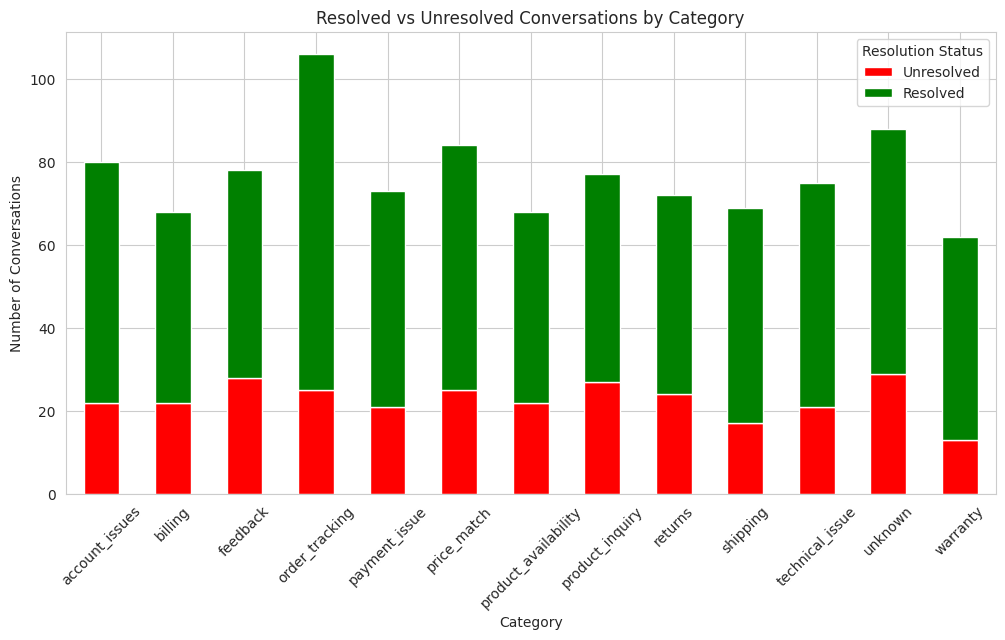

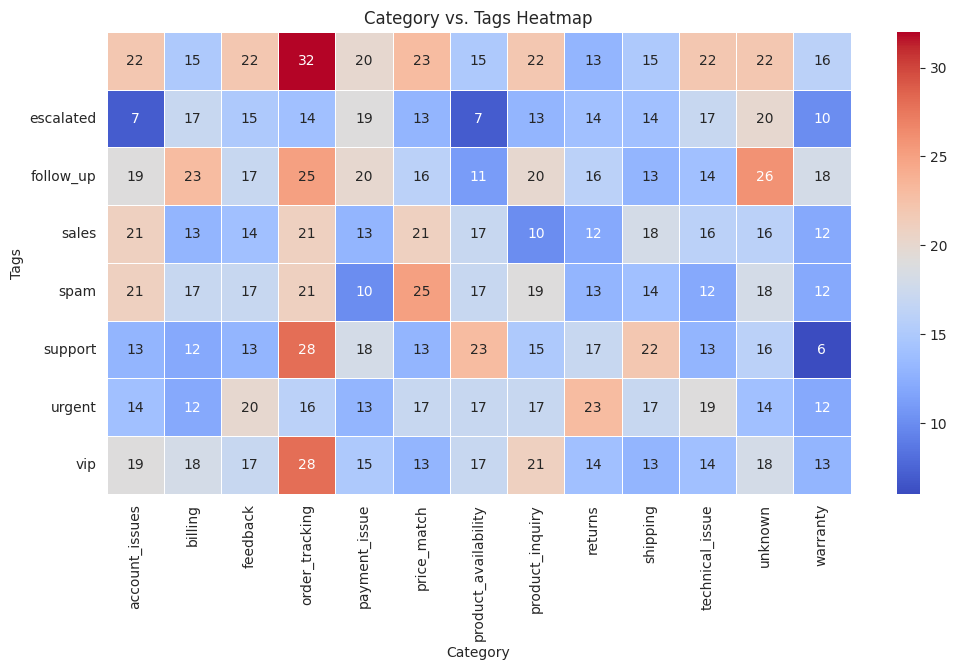

In [195]:
# summary statistic
category_resolved_summary = category_resolved_summary.reset_index()
category_resolved_summary.rename(columns={False: "Unresolved", True: "Resolved"}, inplace=True)
category_resolved_summary.set_index("category")[["Unresolved", "Resolved"]].plot(kind="bar", stacked=True, color=["red", "green"], figsize=(12, 6))

plt.xlabel("Category")
plt.ylabel("Number of Conversations")
plt.title("Resolved vs Unresolved Conversations by Category")
plt.xticks(rotation=45)
plt.legend(title="Resolution Status")

plt.show()
print("\n")

plt.figure(figsize=(12, 6))
sns.heatmap(tags_ag_category, annot=True, cmap="coolwarm", linewidths=0.5, fmt="d")
plt.title("Category vs. Tags Heatmap")
plt.xlabel("Category")
plt.ylabel("Tags")

plt.show()

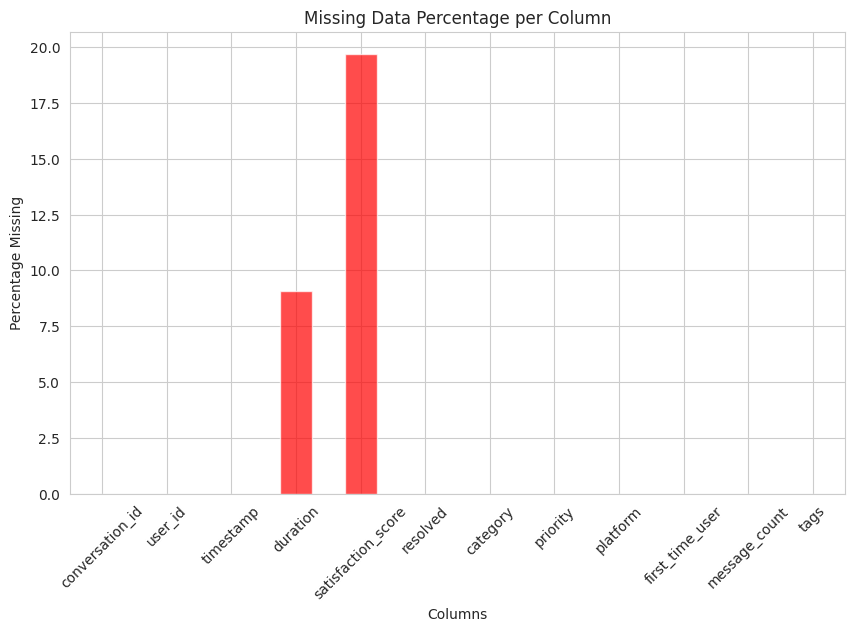

In [196]:
# data quality metric
missing_values_df = pd.DataFrame(conversations)

missing_percent = (missing_values_df.isnull().sum() / len(missing_values_df)) * 100

plt.figure(figsize=(10, 6))
missing_percent.plot(kind='bar', color='red', alpha=0.7)
plt.xlabel("Columns")
plt.ylabel("Percentage Missing")
plt.title("Missing Data Percentage per Column")
plt.xticks(rotation=45)

plt.show()